# STEPS
- data collection 
- understanding the data
- data cleaning
- loading the training set
- data preprocessing - Images
- data preprocessing - Captions 
- data preparation using generator function 
- Word Embeddings
- Model Architecture
- Inference 
- Evaluation 
 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras 
import re
import nltk
from nltk.corpus import stopwords
import string
import json 
from time import time
import pickle 
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model,load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical 
from keras.layers import Input, Dense,Dropout, Embedding, LSTM
from keras.layers.merge import add

Using TensorFlow backend.


In [2]:
# read text captions 
def readTextFile(path):
    with open(path) as f:
        captions=f.read()
    return captions
    

In [3]:
captions=readTextFile("data/Flickr_TextData/Flickr8k.token.txt")
len(captions.split("\n")) # number of captions 


40461

In [4]:
# captions=captions.split("\n")

In [5]:
#print(captions[0])
#print(captions[-1]) #last line is empty so discard the last line 
captions=captions.split('\n')[:-1]

In [6]:
print(len(captions))

40460


In [7]:
# dictonary to map images to the captions it has( key is the image
# id and value is the list containing the captions of images)

In [8]:
captions[0].split("\t")

['1000268201_693b08cb0e.jpg#0',
 'A child in a pink dress is climbing up a set of stairs in an entry way .']

In [9]:
descriptions={}
for x in captions:
    first,second=x.split("\t")
    img_name=first.split(".")[0]
    #if img_name not in descriptions.keys():
    if descriptions.get(img_name) is None:
        descriptions[img_name]=[second]
    else:
        descriptions[img_name].append(second)
    

In [10]:
print(descriptions['1000268201_693b08cb0e'])

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


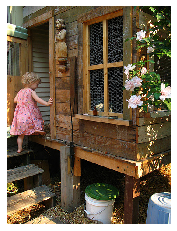

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


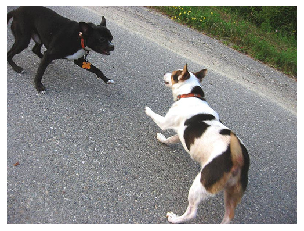

['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']


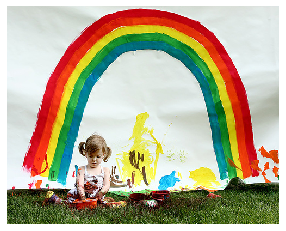

['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .', 'There is a girl with pigtails sitting in front of a rainbow painting .', 'Young girl with pigtails painting outside in the grass .']


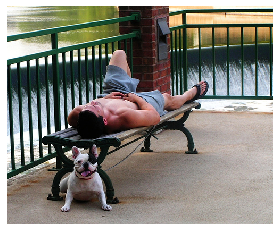

['A man lays on a bench while his dog sits by him .', 'A man lays on the bench to which a white dog is also tied .', 'a man sleeping on a bench outside with a white and black dog sitting next to him .', 'A shirtless man lies on a park bench with his dog .', 'man laying on bench holding leash of dog sitting on ground']


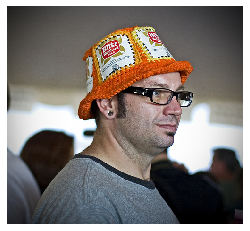

['A man in an orange hat starring at something .', 'A man wears an orange hat and glasses .', 'A man with gauges and glasses is wearing a Blitz hat .', 'A man with glasses is wearing a beer can crocheted hat .', 'The man with pierced ears is wearing glasses and an orange hat .']


In [11]:
img_path="data/Images/"
import cv2
import matplotlib.pyplot as plt
def describe(img_name):
    img=cv2.imread(img_path+img_name+".jpg")
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    print(descriptions[img_name])
for i in list(descriptions.keys())[0:5]:
    describe(i)


In [12]:
# DATA CLEANING 

#### donot remove stop words because we want to generate captions with correct grammer
#### do not do stemmig because the model will learn the stemmed words (like in place of running it will put run)

### how to perform cleaning here? 
#### here we can convert everything to lower case 
#### remove numbers, punctuations, and other symbols , it also helps to reduce vocab size (less vocab size means less number of neurons at dense layer, less parameters and less overfitting and less time to compute 

In [13]:
def clean_text(sentence):
    sentence=sentence.lower()
    sentence=re.sub("[^a-z]+"," ",sentence)
    sentence=sentence.split()
    sentence=[s for s in sentence if len(s)>1]
    sentence=" ".join(sentence)
    return sentence 

In [14]:
clean_text("A cat is sitting over the house # 74")

'cat is sitting over the house'

In [15]:
# clean all the captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i]=clean_text(caption_list[i])
        
    

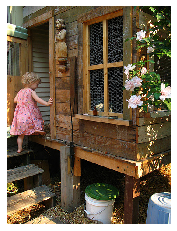

['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin']


In [16]:
for i in list(descriptions.keys())[0:1]:
    describe(i)

In [17]:
# write the data to the text file 
with open("descriptions.txt","w") as f:
    f.write(str(descriptions))


# vocabulary creation 
# vocab - set of all unique words model can predict 
# construct vocab using unique words

In [18]:
descriptions=None
with open("descriptions.txt",'r') as f:
    descriptions=f.read()
json_acceptable_string =descriptions.replace("'","\"")
descriptions=json.loads(json_acceptable_string)

In [19]:
print(type(descriptions))

<class 'dict'>


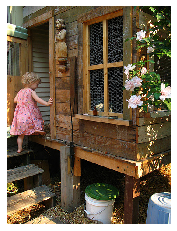

['child in pink dress is climbing up set of stairs in an entry way', 'girl going into wooden building', 'little girl climbing into wooden playhouse', 'little girl climbing the stairs to her playhouse', 'little girl in pink dress going into wooden cabin']


In [20]:
for i in list(descriptions.keys())[0:1]:
    describe(i)

In [21]:
vocab=set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

##### removing words which are less frequent (less than particular threshold)

In [23]:
# total word across all the sentences 
total_words=[]
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]

In [24]:
print(len(total_words))

373837


In [25]:
# filter words from the vocab according to certain threshold frequency

In [26]:
import collections 
counter =collections.Counter(total_words)
freq_cnt=(dict(counter))
print(len(freq_cnt))


8424


In [27]:
#sort this dictionary according to the freq count
sorted_freq_cnt=sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1]) # comparison done on basis of value so x[1]
# filter 
threshold=10
sorted_freq_cnt=[x for x in sorted_freq_cnt if x[1]>threshold]
total_words=[x[0] for x in sorted_freq_cnt]


In [28]:
print(len(total_words)) # this is going to be our vocab

1845


## prepare train and test data 

In [29]:
train_file_data=readTextFile("data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data=readTextFile("data/Flickr_TextData/Flickr_8k.testImages.txt")

In [30]:
train =[row.split(".")[0] for row in train_file_data.split("\n")[:-1]] # -1 ro remove the last line 
#print(train)
test =[row.split(".")[0] for row in test_file_data.split("\n")[:-1]] # -1 ro remove the last line 

In [31]:
print(test[:5])

['3385593926_d3e9c21170', '2677656448_6b7e7702af', '311146855_0b65fdb169', '1258913059_07c613f7ff', '241347760_d44c8d3a01']


In [32]:
#describe(test[2])

In [33]:
# we are going to add start token and end token to every sentence so that our model 
# will know the start and end of the sentence , it will help model to begin the 
# sentence with appropriate word , and everything after end token is discarded 

In [34]:
# adding start and end token to our training data

In [35]:
train_descriptions={}
for img_id in train:
    train_descriptions[img_id]=[]
    for cap in descriptions[img_id]:
        cap_to_append="startseq " + cap+" endseq"
        train_descriptions[img_id].append(cap_to_append)
        

In [36]:
print(train_descriptions['2513260012_03d33305cf'])

['startseq black dog is running after white dog in the snow endseq', 'startseq black dog chasing brown dog through snow endseq', 'startseq two dogs chase each other across the snowy ground endseq', 'startseq two dogs play together in the snow endseq', 'startseq two dogs running through low lying body of water endseq']


# Transfer Learning 
- convert images to features 
- convert text to features

### step 1 image feature extraction

In [37]:
model=ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()
#resnet is not sequential model , there is branching , so we see connected to column and these are also called skip connection
# it avoids vanishing gradient 

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [38]:
# GlobalAveragePooling2 will be our features
model_new=Model(model.input,model.layers[-2].output)

In [39]:
# print(model.layers[-2])
# print(model.layers[-2].output)

In [40]:
# so if we give m images to our model_new then the model will return featrue vector m*2048 dimension

In [41]:
def preprocess_img(img):
    img=image.load_img(img,target_size=(224,224))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0) # you will feed images in batch in model not
    #single image at a time so expand the dimension 3 to 4 , new dimension 
    #added at front as 1 so [1,224,224,3]
    img=preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


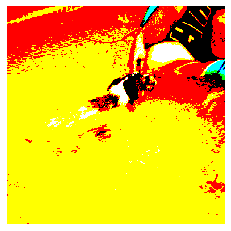

In [42]:
img_name="2677656448_6b7e7702af"
img=preprocess_img(img_path+img_name+".jpg")
plt.imshow(img[0])
plt.axis("off")
plt.show()
# from each pixel subtracted the channel mean 

In [43]:
def encode_image(img):
    img=preprocess_img(img)
    feature_vector=model_new.predict(img)
    #print(feature_vector.shape)
    feature_vector=feature_vector.reshape((-1,))
    return feature_vector

In [44]:
print(encode_image(img_path+img_name+".jpg").shape)
print(img_path)

(2048,)
data/Images/


In [45]:
start=time()
encoding_train={}
#image_id --> feature_vector extracted from Resnet Image
for ix, img_id in enumerate(train):
    #print(ix,img_id)
    path=img_path+img_id+".jpg"
    encoding_train[img_id]=encode_image(path)
    if(ix%100==0):
        print("encoding progress ",ix)
end=time()
print("time= ",end-start)

encoding progress  0
encoding progress  100
encoding progress  200
encoding progress  300
encoding progress  400
encoding progress  500
encoding progress  600
encoding progress  700
encoding progress  800
encoding progress  900
encoding progress  1000
encoding progress  1100
encoding progress  1200
encoding progress  1300
encoding progress  1400
encoding progress  1500
encoding progress  1600
encoding progress  1700
encoding progress  1800
encoding progress  1900
encoding progress  2000
encoding progress  2100
encoding progress  2200
encoding progress  2300
encoding progress  2400
encoding progress  2500
encoding progress  2600
encoding progress  2700
encoding progress  2800
encoding progress  2900
encoding progress  3000
encoding progress  3100
encoding progress  3200
encoding progress  3300
encoding progress  3400
encoding progress  3500
encoding progress  3600
encoding progress  3700
encoding progress  3800
encoding progress  3900
encoding progress  4000
encoding progress  4100
enco

In [46]:
#store everything to the disk // 
# use picke to dump data to disk , picke allows to switch between files in the ram to disk 
with open("encoded_train_features.pkl","wb") as f: # write binary mode
    pickle.dump(encoding_train,f)

In [47]:

# with open('encoded_train_features.pkl', 'rb') as f:
#     encoded_train_features = pickle.load(f)
# with open('encoded_test_features.pkl', 'rb') as f:
#     encoded_test_features = pickle.load(f)

In [48]:
start=time()
encoding_test={}
#image_id --> feature_vector extracted from Resnet Image
for ix, img_id in enumerate(test):
    #print(ix,img_id)
    path=img_path+img_id+".jpg"
    encoding_test[img_id]=encode_image(path)
    if(ix%100==0):
        print("test encoding progress ",ix)
end=time()
print("time= ",end-start)

test encoding progress  0
test encoding progress  100
test encoding progress  200
test encoding progress  300
test encoding progress  400
test encoding progress  500
test encoding progress  600
test encoding progress  700
test encoding progress  800
test encoding progress  900
time=  213.52017211914062


In [49]:
with open("encoded_test_features.pkl","wb") as f: # write binary mode
    pickle.dump(encoding_test,f)

### data preprocessing for captions 


- we also need to create date generator function because entire data cannot load into RAM at a time 

In [50]:
# vocab 
len(total_words)

1845

In [51]:
word_to_idx={}
idx_to_word={}
for i,word in enumerate(total_words):
    word_to_idx[word]=i+1
    idx_to_word[i+1]=word #every sentence will have different length so we will put zero when no word is there that's why here we start with 1
    

In [52]:
#word to index -->> caption generator model -->> index to word 
# index is feed to model and index is predicted 

In [53]:
print(idx_to_word[6])
print(word_to_idx['in'])
print(len(idx_to_word))

dog
1
1845


In [54]:
# we also have to add startseq and endseq to the above dictonaries
idx_to_word[1846]="startseq"
idx_to_word[1847]="endseq"
word_to_idx["startseq"]=1846
word_to_idx["endseq"]=1847
vocab_size=len(word_to_idx)+1 # 1 because 0 too

In [55]:
#find the largest length of caption for feeding the data to mdoel because we feed the data in batch which contain multiple sentences and small sentences at end we put 0 

In [56]:
max_len=0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len=max(max_len,len(cap.split()))
print(max_len)

35


## data loader (generator)

#### image captioning as supervised learning 
- y =f(x) // where x is the image and y is the caption
- you cannot generate entire sentence at a time 
- during training our model though our model predicts the wrong output at a particular step we are going to give correct input to the next lstm cell so that it can learn to predict the correct output (at training time at every step we are going to feed the ground truth 
- prob of sentence =[p(w1/w0) * p(w2/(w0w1))*.....] // this is called joint probability which we have to mazimize 
- in case of testing we feed what was previously generated by our model 
#### this is the concept of language modelling

In [57]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    x1,x2,y=[],[],[] # x1 image vector, x2 parital caption  
    n=0
    while True:
        for key,desc_list in train_descriptions.items():
            n+=1
            photo=encoding_train[key]
            for desc in desc_list:
                seq=[word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi=seq[0:i]
                    yi=seq[i]
                    # 0 denote padding word
                    xi=pad_sequences([xi], maxlen=max_len,value=0,padding='post')[0] # pad_sequences available in keras 
                    # pad_sequences accepts the 2d matrix but we have 1d matrix so we send [xi] where xi is list and output returned is [[1,2,3]] form so we extract [1,2,3] as the first element by putting [0] at last  
                    yi =to_categorical([yi], num_classes=vocab_size)[0] # number in the output as onehot value 
                    x1.append(photo)# 2648 dimension 
                    x2.append(xi) #35 dimension , later we will do glove embedding 
                    y.append(yi) # size same as vocab size
                #we are not using return because its the generator and its remember its previous state
                if n==batch_size:
                    yield[[np.array(x1),np.array(x2)],np.array(y)]
                    x1,x2,y=[],[],[]
                    n=0

### what we have done above is 
- we have 5 captions for each image and suppose each caption has 7 words then we have 1*5*7=35 pair of x,y 

## word embeddings 

In [58]:
# caption word indices to glove embeddings
# how transfer learning for text 
# whenever you pass the data to the RNN the data must pass through the embedding layer
# we can train the embedding layer as we go with our training or we can pre-intialize 
# for pre-initializing we are going to use glove embedding (glove 6B50D.txt) which contain glove embedding of 6 billion words and each word has a fifty dimensional vector
# in our case we just need the words which are in our vocab 
# so we will get vocab_size()*50 dimension matrix  

In [59]:
f=open("data/glove.6B.50d.txt",encoding='utf-8')


In [60]:
embedding_index={}
for line in f:
    values=line.split()
    #print(values)
    word=values[0]
    word_embedding=np.array(values[1:],dtype='float')
    embedding_index[word]=word_embedding
    
    
    

In [61]:
f.close()

In [62]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [63]:
def get_embedding_matrix():
    emb_dim=50
    matrix=np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector=embedding_index.get(word)
        if embedding_vector is not None:
            matrix[idx]=embedding_vector
    return matrix
# if the particular word is not present in glove vector then the matrix will contain 0 vector corresponding to it 

In [64]:
embedding_matrix=get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

## model architecture 

- img feature + partial sequence -->> model --> next word 
#### we are using keras functional api because model is complex (not sequential)

In [65]:
input_img_features=Input(shape=(2048,))
inp_img1=Dropout(0.3)(input_img_features)
inp_img2=Dense(256,activation='relu')(inp_img1) 


In [66]:
#captions as input
input_captions=Input(shape=(max_len,)) # 35 max_len of sentence ,#batch size can be any
inp_cap1=Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2=Dropout(0.3)(inp_cap1)
inp_cap3=LSTM(256)(inp_cap2) # 256 denotes the output size whcih is passed from one Lstm cell to other 

In [67]:
decoder1=add([inp_img2,inp_cap3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)
# combined model 
model =Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [68]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [69]:
# initialize the embedding layer 
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable=False

In [70]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

### training of model

In [71]:
epochs=20 
batch_size=3
steps=len(train_descriptions)//batch_size
print(steps)
# if we call generator 2000 times all the train images will pass through it

2000


In [72]:
def train():
    for i in range(epochs):
        generator=data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('model_weights/model_'+str(i)+'.h5')
        

In [74]:
start=time()
train()


Epoch 1/1
2000/2000 [==============================] - 551s 276ms/step - loss: 4.0885
Epoch 1/1
2000/2000 [==============================] - 588s 294ms/step - loss: 3.5330
Epoch 1/1
2000/2000 [==============================] - 626s 313ms/step - loss: 3.2941
Epoch 1/1
2000/2000 [==============================] - 672s 336ms/step - loss: 3.1434
Epoch 1/1
2000/2000 [==============================] - 666s 333ms/step - loss: 3.0357
Epoch 1/1
2000/2000 [==============================] - 681s 340ms/step - loss: 2.9494
Epoch 1/1
2000/2000 [==============================] - 692s 346ms/step - loss: 2.8831
Epoch 1/1
2000/2000 [==============================] - 686s 343ms/step - loss: 2.8300
Epoch 1/1
2000/2000 [==============================] - 627s 314ms/step - loss: 2.7812
Epoch 1/1
2000/2000 [==============================] - 582s 291ms/step - loss: 2.7398
Epoch 1/1
2000/2000 [==============================] - 574s 287ms/step - loss: 2.7064
Epoch 1/1
2000/2000 [==============================] -

In [87]:
print(time()-start)
model=load_model('./model_weights/model_19.h5')# weight after 10th epoch 

40942.8649892807


## predictions


In [88]:
def predict_caption(photo):
    in_text="startseq"
    for i in range(max_len):
        sequence=[word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence=pad_sequences([sequence],maxlen=max_len,padding='post')
        ypred=model.predict([photo,sequence])
        ypred=ypred.argmax() #word with max probability - greedy smapling (can also use beam search)
        word=idx_to_word[ypred]
        in_text+=(' '+word)
        if word=='endseq':
            break
    final_caption=in_text.split()[1:-1]
    final_caption=' '.join(final_caption)
    return final_caption

In [84]:
# pick some random images

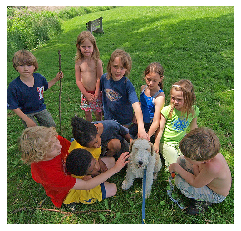

['children one with stick and six petting dog with blue leash', 'group of children are petting white dog on the grass', 'group of children gather around white dog on the grass outside', 'group of children playing with dog', 'group of children surround and pet white dog with blue collar on grass']
generated caption
two children are sitting on bench and making shoes


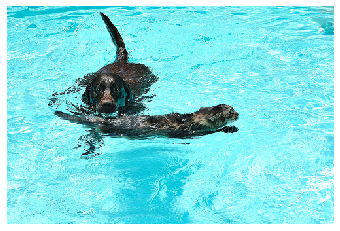

['black dog paddles behind black cat in body of water', 'dog and cat are swimming in swimming pool', 'two black dogs are dog paddling in sparkling blue pool', 'two black dogs are swimming in pool', 'two dogs swimming in pool']
generated caption
black dog is swimming in pool after tennis balls


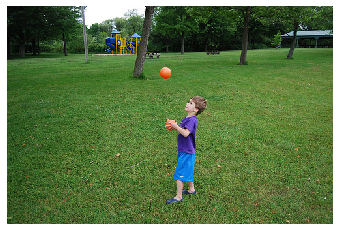

['boy in park playing with two orange balls', 'boy in purple shirt tosses orange balls on lawn', 'little boy in purple shirt and blue shorts playing with orange balls', 'boy playing on the grass with an orange ball', 'little boy juggling orange balls in the park with playground behind him']
generated caption
boy in blue shirt plays with tennis ball in the grass


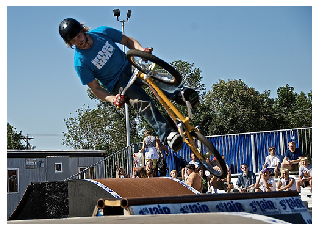

['man is doing tricks on bicycle on ramps in front of crowd', 'man on bike executes jump as part of competition while the crowd watches', 'man rides yellow bike over ramp while others watch', 'bike rider jumping obstacles', 'bmx biker jumps off of ramp']
generated caption
man is jumping off of the air in the air


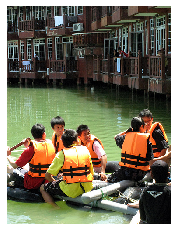

['group of boys are wearing yellow life vests and are on make shift raft', 'group of people on boat', 'boys in life jackets on watercraft', 'several young people in life jackets are sitting on something floating in water', 'the boys in life jackets smile and laugh while riding in boat']
generated caption
two men are sitting in the water


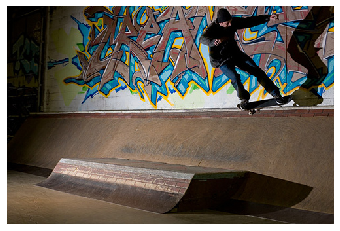

['man rides his skateboard with his shadow falling on wall covered in graffiti', 'skateboarder grinding lip', 'skateboarder is jumping through the air in front of graffiti covered wall', 'skateboarder performs skateboard trick against graffiti wall', 'skateboarder performs tricks on ramp in front of wall with graffiti']
generated caption
skateboarder is performing jump on his bike


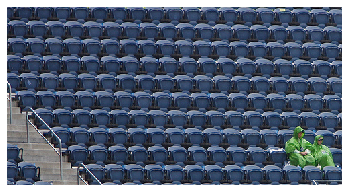

['empty seats at stadium except for two people in green rain ponchos', 'the two people wearing green are sitting down and surrounded by empty seats', 'two lonely fans in green ponchos sit in stadium', 'two people in green sit in an otherwise empty stadium', 'two people wearing green raincoats sit in blue bleachers that are otherwise empty']
generated caption
man in blue shirt and jeans is standing on stage


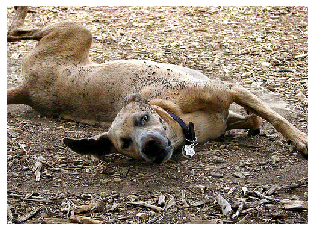

['dirty tan dog rolling in the dirt and looking right at the camera', 'dog lies on the ground', 'dog rolls on the ground', 'dog with black collar rolling in dirt and dried leaves', 'the brown dog is rolling around in the dirt']
generated caption
two dogs are sniffing each other in the woods


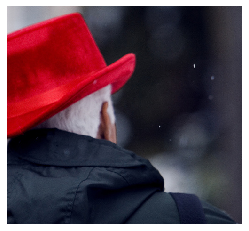

['an older man with white hair blue jacket and bright red hat', 'an old man wearing red hat and black raincoat', 'an old man with white hair in red hat', 'person is red hat and winter jacket is looking into the distance', 'person with gray hair wears red hat and watches it snow']
generated caption
woman in red shirt and helmet is sitting in front of red plastic


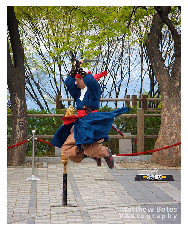

['japanese swordsman jumps into the air', 'man in blue outfit is swinging sword in the air', 'an actor dressed as pirate performs in an outdoor park', 'person wearing blue robe is in the air holding sword', 'man in martial arts style costume jumping in midair']
generated caption
boy in red shirt and jeans is jumping on his skateboard


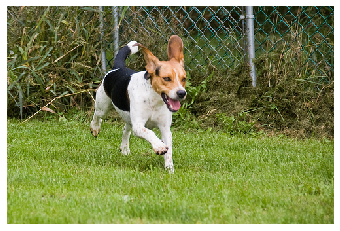

['black brown and white dog is running beside green fence in grassy garden', 'dog is galloping through the grass', 'dog runs through lush green lawn', 'tri colored dog is running on the green grass', 'dog running through grass in fenced in area']
generated caption
two dogs are running through field


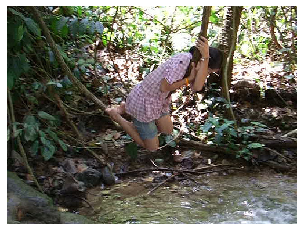

['girl swings on vine over water', 'girl tries holding onto vine so she so fall into the water', 'girl wearfing pink swings over creek', 'the girl is swinging on rope over small pond', 'woman swinging above water while holding vine']
generated caption
boy in shorts and shorts is climbing rock face


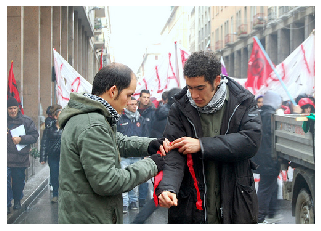

['man helps another man tie red ribbon onto his arm', 'man helps tie red ribbon around another man right arm during street parade', 'man is tying red arm band around another mans arm in the street', 'one man helps another attach red ribbon to his forearm in the midst of large group of people', 'two men stand together one is putting something red on his arm']
generated caption
man in black shirt and tie is standing next to woman in black shirt


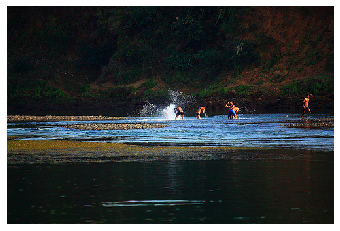

['group of friends play in lake', 'five people are in natural water source', 'many children play in the water', 'people in bathing suits bend down and reach into the water of lake', 'several people are playing outside in the water']
generated caption
man in wetsuit is jumping into the water headfirst into the water


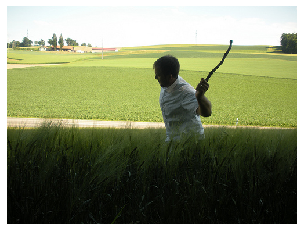

['man in white shirt swinging stick', 'man in white shirt walks in the tall grass holding stick', 'man is walking in field carrying stick', 'man with stick in his left hand in field', 'man near golf course preparing to throw stick']
generated caption
young boy is playing with soccer ball in the grass


In [89]:
for i in range(15):
    idx=np.random.randint(0,1000)
    all_img_names=list(encoding_test.keys())
    img_name=all_img_names[idx]
    photo_2048=encoding_test[img_name].reshape((1,2048))
    describe(img_name)
    print("generated caption")
    caption=predict_caption(photo_2048)
    print(caption)
    